# Dhruv Rana #

### 0. Import Library ###

In [712]:
import numpy as np
import scipy as sp
import control.matlab as matlab
import matplotlib.pyplot as plt 
import matplotlib
import itertools
import pandas

### 1. System Parameters ###

In [713]:
A = np.array([[-0.0366,  0.0271,  0.0188, -0.4555],
              [ 0.0482, -1.0100,  0.0024, -4.0208],
              [ 0.1002,  0.2855, -0.7070,  1.3229],
              [ 0     ,  0     ,  1.0000,  0     ]], dtype=np.float64)

B1 = np.array([[0.4422,  3.0447, -5.52, 0]], dtype=np.float64).T
B2 = np.array([[0.1761, -7.5922,  4.99, 0]], dtype=np.float64).T

X0 = np.array([[0, 0, 0, 1]], dtype=np.float64).T

Q1_diag = [3.5,2.0,4.0,5.0]
Q2_diag = [1.5,6.0,3.0,1.0]

R11 = np.array([[1.0]], dtype=np.float64)
R12 = np.array([[0.25]], dtype=np.float64)
R21 = np.array([[0.6]], dtype=np.float64)
R22 = np.array([[2.0]], dtype=np.float64)

In [714]:
Q1 = np.array(np.diag(Q1_diag), dtype=np.float64)
Q2 = np.array(np.diag(Q2_diag), dtype=np.float64)

S11 = np.array(B1 * np.linalg.inv(R11) * R11 * np.linalg.inv(R11) * B1.T, dtype=np.float64)
S21 = np.array(B1 * np.linalg.inv(R11) * R21 * np.linalg.inv(R11) * B1.T, dtype=np.float64)

S12 = np.array(B2 * np.linalg.inv(R22) * R12 * np.linalg.inv(R22) * B2.T, dtype=np.float64)
S22 = np.array(B2 * np.linalg.inv(R22) * R22 * np.linalg.inv(R22) * B2.T, dtype=np.float64)

### 2. Inital Guess for K1 & K2 ###

In [715]:
# Inital K1 and K2 according to  (Freiling et al., 1996)
K1_0_trial,_,_= matlab.care(A,B1,Q1,R11)
K1_0 = np.array(K1_0_trial)
print("K1_0_trial:-")
print(K1_0_trial)


K2_0_trial,_,_= matlab.care(A,B2,Q2,R22)
K2_0_trial = np.array(K2_0_trial)
print("\nK2_0_trial:-")
print(K2_0_trial)


K1_0_trial:-
[[16.97910304 -0.16569379  0.98587488 -2.49786149]
 [-0.16569379  0.8870862   0.36072185 -0.73458675]
 [ 0.98587488  0.36072185  0.60669949  0.05617244]
 [-2.49786149 -0.73458675  0.05617244  7.81130072]]

K2_0_trial:-
[[ 7.42562859 -1.30206994 -2.41029584 -2.94875135]
 [-1.30206994  1.60901825  1.9424263   0.51437132]
 [-2.41029584  1.9424263   3.3254311   1.3973657 ]
 [-2.94875135  0.51437132  1.3973657   5.16723838]]


In [716]:
# Inital K1 and K2 according to (Li and Gajic, 1995)
K1_0= sp.linalg.solve_continuous_are(A,B1,Q1,R11)
K1_0 = np.array(K1_0)
print("K1_0:-")
print(K1_0)

K2_0= sp.linalg.solve_continuous_are( (A - np.matmul(S11,K1_0)) , B2 , Q2 + np.matmul(K1_0,np.matmul(S21,K1_0)) , R22)
K2_0 = np.array(K2_0)
print("\nK2_0:-")
print(K2_0)

K1_0:-
[[16.97910304 -0.16569379  0.98587488 -2.49786149]
 [-0.16569379  0.8870862   0.36072185 -0.73458675]
 [ 0.98587488  0.36072185  0.60669949  0.05617244]
 [-2.49786149 -0.73458675  0.05617244  7.81130072]]

K2_0:-
[[ 3.58568712  0.20390521  0.24152958 -1.80967736]
 [ 0.20390521  0.60439474  0.29187757 -0.10016983]
 [ 0.24152958  0.29187757  0.40798729  0.08036749]
 [-1.80967736 -0.10016983  0.08036749  4.20027031]]


### 3. Solve the Coupled Algebraic Riccati Equations ###

In [717]:
max_iterations = 11

K1 = [K1_0]
K2 = [K2_0]

K1_iter = np.zeros((max_iterations+1, len(K1_0.flatten().T) ))
K2_iter = np.zeros((max_iterations+1, len(K2_0.flatten().T) ))

K1_iter[0] = K1_0.flatten()
K2_iter[0] = K2_0.flatten()

F1 = np.zeros((max_iterations+1, len((np.linalg.inv(R11)* np.matmul(B1.T,(K1[0]))).flatten())))
F2 = np.zeros((max_iterations+1, len((np.linalg.inv(R22)* np.matmul(B2.T,(K2[0]))).flatten())))

F1[0] = np.linalg.inv(R11)* np.matmul(B1.T,(K1[0]))
F2[0] = np.linalg.inv(R22)* np.matmul(B2.T,(K2[0]))

J1 = np.zeros((max_iterations))
J2 = np.zeros((max_iterations))

# Test against actual output from  (Freiling et al., 1996)
K1_trial = [K1_0_trial]
K2_trial = [K2_0_trial]

for i in range(1,max_iterations+1):
    #  (Freiling et al., 1996)
    next_K1_trial = sp.linalg.solve_continuous_are( (A - np.matmul(S22,K2[i-1])), B1 , (Q1 + (np.matmul(K2[i-1],np.matmul(S12,K2[i-1]))) ), R11  ) 
    next_K2_trial = sp.linalg.solve_continuous_are( (A - np.matmul(S11,K1[i-1])), B2 , (Q2 + (np.matmul(K1[i-1],np.matmul(S21,K1[i-1]))) ),  R22 ) 
    K1_trial.append(np.array( next_K1_trial ))
    K2_trial.append(np.array( next_K2_trial ))

    # Solve using Lyapunov Iterations (Li and Gajic, 1995) 
    next_K1 = sp.linalg.solve_lyapunov( (A - np.matmul(S11,K1[i-1]) - np.matmul(S22,K2[i-1])).T, -(Q1 + (np.matmul(K1[i-1],np.matmul(S11,K1[i-1]))) + (np.matmul(K2[i-1],np.matmul(S12,K2[i-1]))) ) ) 
    next_K2 = sp.linalg.solve_lyapunov( (A - np.matmul(S11,K1[i-1]) - np.matmul(S22,K2[i-1])).T, -(Q2 + (np.matmul(K1[i-1],np.matmul(S21,K1[i-1]))) + (np.matmul(K2[i-1],np.matmul(S22,K2[i-1]))) ) )
    K1.append(np.array( next_K1 ))
    K2.append(np.array( next_K2 ))
    K1_iter[i] = next_K1.flatten()
    K2_iter[i] = next_K2.flatten()

    J1[i-1] = (1/2) * np.matmul ( X0.T , np.matmul(K1[i] , X0) )
    J2[i-1] = (1/2) * np.matmul ( X0.T , np.matmul(K2[i] , X0) )

    F1[i] = (np.linalg.inv(R11)* np.matmul(B1.T,(K1[i]))).flatten()
    F2[i] = (np.linalg.inv(R22)* np.matmul(B2.T,(K2[i]))).flatten()

### 4. Solution ###

In [718]:
print(f"K1_{max_iterations} :-")
print(K1[-1])
print("K1_gain :-")
print(np.linalg.inv(R11)* np.matmul(B1.T,(K1[-1])))
print()
print(f"K2_{max_iterations} :-")
print(K2[-1])
print("K2_gain :-")
print(np.linalg.inv(R22)*B2.T.dot(K2[-1]))

K1_11 :-
[[ 7.65859301  0.64378599  0.63982315 -3.08312621]
 [ 0.64378599  0.28775293  0.28554716 -0.09447086]
 [ 0.63982315  0.28554716  0.56200666  0.22701676]
 [-3.08312621 -0.09447086  0.22701676  6.69871617]]
K1_gain :-
[[ 1.81494124 -0.41541678 -1.94994156 -2.90412632]]

K2_11 :-
[[ 3.45787531  0.15681142  0.20465317 -1.84796418]
 [ 0.15681142  0.62347817  0.28894605 -0.07113316]
 [ 0.20465317  0.28894605  0.40137661  0.07289788]
 [-1.84796418 -0.07113316  0.07289788  3.78502749]]
K2_gain :-
[[ 0.21980375 -1.63205784 -0.07741374  0.28919556]]


In [719]:
print(f"K1_trial_{max_iterations} :-")
print(K1_trial[-1])
print("K1_trial_gain :-")
print( np.linalg.inv(R11) * np.matmul(B1.T,(K1_trial[-1])) )
print()
print(f"K2_trial_{max_iterations} :-")
print(K2_trial[-1])
print("K2_trial_gain :-")
print( np.linalg.inv(R22) * np.matmul(B2.T, (K2_trial[-1])) )

K1_trial_11 :-
[[ 7.65859301  0.64378599  0.63982315 -3.08312621]
 [ 0.64378599  0.28775293  0.28554716 -0.09447086]
 [ 0.63982315  0.28554716  0.56200666  0.22701676]
 [-3.08312621 -0.09447086  0.22701676  6.69871617]]
K1_trial_gain :-
[[ 1.81494124 -0.41541678 -1.94994156 -2.90412632]]

K2_trial_11 :-
[[ 3.45787531  0.15681142  0.20465317 -1.84796418]
 [ 0.15681142  0.62347817  0.28894605 -0.07113316]
 [ 0.20465317  0.28894605  0.40137661  0.07289788]
 [-1.84796418 -0.07113316  0.07289788  3.78502749]]
K2_trial_gain :-
[[ 0.21980375 -1.63205784 -0.07741374  0.28919556]]


### 5. Figures and Tables ###

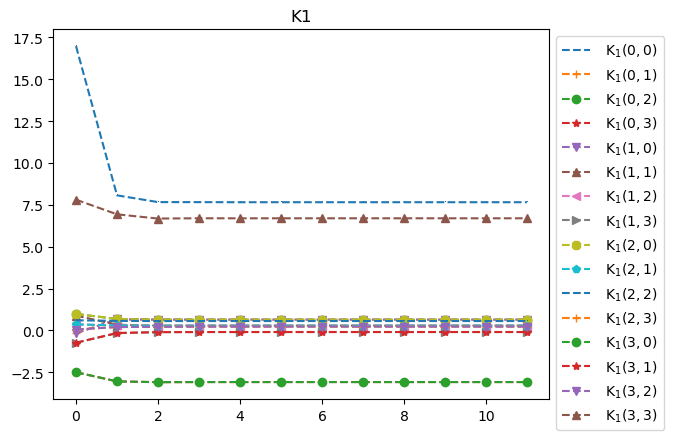

In [720]:
markers = itertools.cycle((',', '+', 'o', '*','v','^','<','>','8',"p")) 

for i in range(len(K1_iter[0])):
    
    row = int(i/len(K1_0))
    col = int(i%len(K1_0[0]))

    K = K1_iter[:,i]

    plt.plot(range(len(K1_iter)), K ,linestyle='--',marker=next(markers),label = f" K$_1 ({row},{col})$ ")
    
plt.legend(loc='best',bbox_to_anchor=(1, 1))
plt.title("K1")
plt.show()

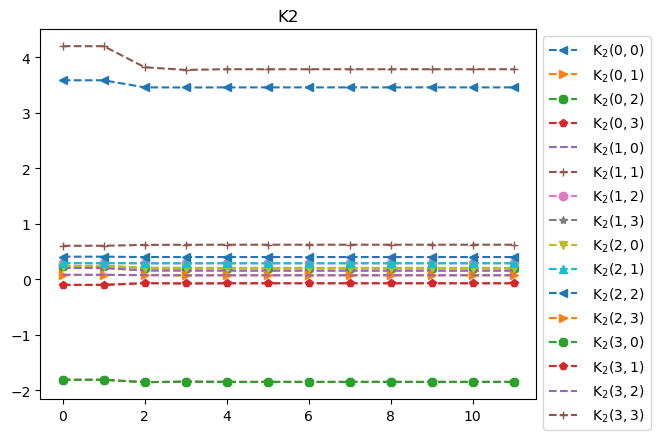

In [721]:
for i in range(len(K2_iter[0])):
    
    row = int(i/len(K2_0))
    col = int(i%len(K2_0[0]))

    K = K2_iter[:,i]

    plt.plot(range(len(K2_iter)), K ,linestyle='--',marker=next(markers),label = f" K$_2 ({row},{col})$ ")
    
plt.legend(loc='best',bbox_to_anchor=(1, 1))
plt.title("K2")
plt.show()

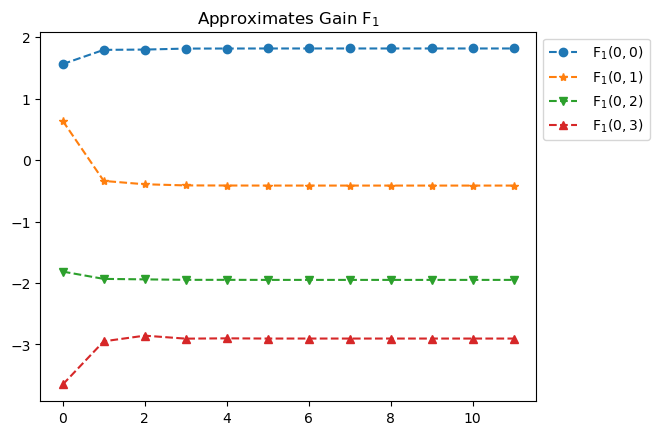

In [722]:
for i in range(len(F1[0])):
    
    row = int(i/len(F1))
    col = int(i%len(F1[0]))

    F = F1[:,i]

    plt.plot(range(len(F)), F ,linestyle='--',marker=next(markers),label = f" F$_1 ({row},{col})$ ")
    
plt.legend(loc='best',bbox_to_anchor=(1, 1))
plt.title("Approximates Gain F$_1$")
plt.show()

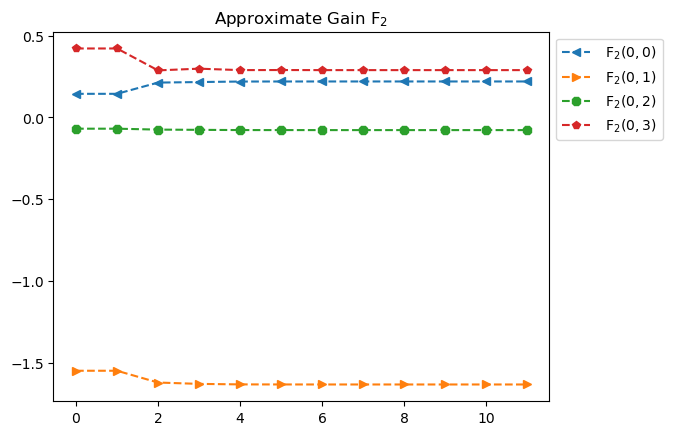

In [723]:
for i in range(len(F2[0])):
    
    row = int(i/len(F2))
    col = int(i%len(F2[0]))

    F = F2[:,i]

    plt.plot(range(len(F)), F ,linestyle='--',marker=next(markers),label = f" F$_2 ({row},{col})$ ")
    
plt.legend(loc='best',bbox_to_anchor=(1, 1))
plt.title("Approximate Gain F$_2$")
plt.show()

In [724]:
def X_t (t, S1, K1, S2, K2, X0):
    X = sp.linalg.expm((A - (np.matmul(S1,K1)) - (np.matmul(S2,K2)))*t)
    return (np.matmul(X,X0))

end_time = 15 #sec
time = np.linspace(0,end_time,end_time*100)

X = np.zeros((len(time),len(X0)))
U1 = np.zeros((len(time)))
U2 = np.zeros((len(time)))

for i in range(len(time)):
    X[i] = X_t(time[i],S11,K1[-1],S22,K2[-1],X0).T.squeeze()
    U1[i] = -1 * np.matmul( np.linalg.inv(R11)* np.matmul(B1.T,(K1[-1])), X[i])
    U2[i] = -1 * np.matmul( np.linalg.inv(R22)* np.matmul(B2.T,(K2[-1])), X[i])


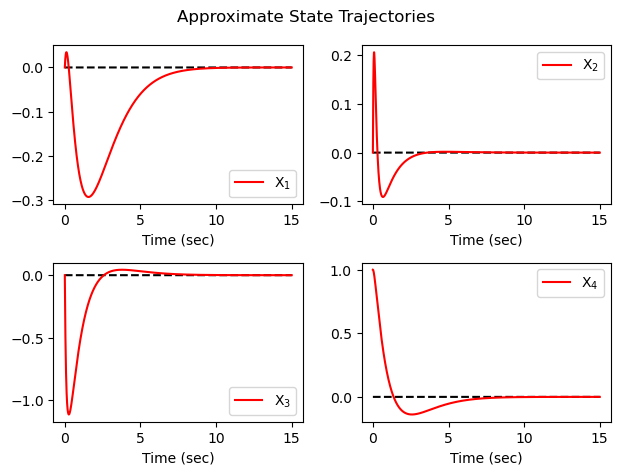

In [725]:
for i in range(1,len(X[0])+1):
    plt.subplot(2,2,i)
    plt.plot(time, np.zeros_like(time), 'k--')
    plt.plot(time,X[:,i-1],'r', label=f"X$_{i}$")
    plt.xlabel("Time (sec)")
    plt.legend(loc='best')

plt.suptitle("Approximate State Trajectories")
plt.tight_layout()
plt.show()

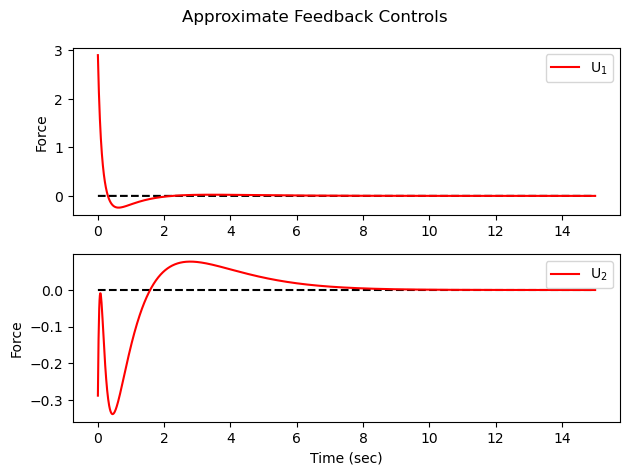

In [726]:
plt.subplot(2,1,1)
plt.plot(time, np.zeros_like(time), 'k--')
plt.plot(time, U1, 'r', label="U$_1$")
plt.ylabel("Force")
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(time, np.zeros_like(time), 'k--')
plt.plot(time, U2, 'r', label="U$_2$")
plt.xlabel("Time (sec)")
plt.ylabel("Force")
plt.legend(loc='best')

plt.suptitle("Approximate Feedback Controls")
plt.tight_layout()
plt.show()

In [727]:
data= {"J1": np.concatenate((J1,np.array([J1[-1]]))), "J2":np.concatenate((J2,np.array([J2[-1]])))}
iteration = [f"iteraion {i}" for i in range (max_iterations)]
iteration.append("optimal = ")
df = pandas.DataFrame(data, index=iteration)
df.style

,J1,J2
iteraion 0,3.467780,2.100135
iteraion 1,3.341168,1.910400
iteraion 2,3.350130,1.886189
iteraion 3,3.348513,1.892976
iteraion 4,3.349377,1.892118
iteraion 5,3.349302,1.892528
iteraion 6,3.349359,1.892492
iteraion 7,3.349355,1.892514
iteraion 8,3.349358,1.892513
iteraion 9,3.349358,1.892514


## Refrences ##
[1] Freiling G., Jank G. & Abou-Kandil H. (1996). On Global Existence of Solutions to Coupled
Matrix Riccati Equations in Closed-Loop Nash Games, IEEE Transaction on
Automatic Control, 41, 2, pp. 264-269

[2] Li, T. & Gajic, Z. (1995). Lyapunov iterations for solving coupled algebraic Riccati equations
of Nash differential games and algebraic Riccati equations of zero-sum games, In:
New Trends in Dynamic Games, G. Olsder (Ed.), Birkhauser, pp. 333-351